# **Conformal Prediction Tutorial**

## 0. **Setup**

In [1]:
import torch
from torchvision import models
from datasets import *
from tqdm import tqdm

## **1. Conformal Prediction (classification)**

### **1.1 Overview**

Conformal prediction is a way to generate **prediction sets** for *any* model.
1. suppose we have a $K$-class classification model that outputs softmax scores for each class: $\hat{f}(x) \in [0,1]^K$
2. we reserve a moderate amount, e.g. 500, of unseen i.i.d samples $(X_1,Y_1),...,(X_n,Y_n)$ for *calibration*

Using the model $\hat{f}$ (1) and the calibration set (2), we want to construct a prediction set of possible labels $\mathcal{C}(X_{test}) \subset \{1,...,K\}$ that is valid in that

$$1-\alpha \leq \mathbb{P}(Y_{test}\in \mathcal{C}(X_{test}))\leq 1-\alpha +\frac{1}{n+1}$$

* $(X_{test},Y_{test})$ is a fresh test point from the same distribution 
* $\alpha\in[0,1]$ is a user-chosen error rate, such as 0.1

In words, the probability that the prediction set contains the true label is *almost* exactly $1-\alpha$, this is called *marginal coverage*

### **1.2 Calibration Step**

To construct the set $\mathcal{C}$ we perform a calibration step. The following is an example procedure
1. For every sample $(X_i,Y_i)$ in the calibration set, get conformal score $s_i=1-\hat{f}(X_i)_{Y_i}$ which is one minus the softmax output of the true class
2. define $\hat{q}$ to be the $\frac{\lceil (n+1)(1-\alpha) \rceil}{n}$ empirical quantile of $s_1,...,s_n$
3. for a new test point $X_{test}$, create a prediction set $\mathcal{C}(X_{test})=\{y:\hat{f}(X_{test})_y \geq 1-\hat{q}\}$

This algorithm is guaranteed to satisfy the desired condition above for any model and data distribution

#### **1.2.1 Code Example**

First get prepare the data and model

In [2]:
# load a model
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda').eval()

# load a validation set
bs = 256
val_loader = load_imagenet(bs,1234,False)

if "mnv3_scores.pt" not in os.listdir():
    # get softmax scores
    with torch.no_grad():
        sm_scores = torch.zeros((50000,1000))
        true_labels = torch.zeros(50000)
        for i,(imgs,labels) in enumerate(tqdm(val_loader)):
            # get calibration samples
            sm_scores[i*bs:i*bs+bs,:] = torch.nn.functional.softmax(model(imgs.to('cuda')),dim=1).cpu()
            true_labels[i*bs:i*bs+bs] = labels

    torch.save([sm_scores,true_labels],"mnv3_scores.pt")
else:
    sm_scores,true_labels = torch.load("mnv3_scores.pt")

n = 1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

# Split the softmax scores into calibration and validation sets (save the shuffling)
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]
cal_smx, val_smx = sm_scores[cal_idxs,:].numpy(), sm_scores[val_idxs,:].numpy()
cal_labels, val_labels = true_labels[cal_idxs].numpy().astype(int), true_labels[val_idxs].numpy().astype(int)

Next do conformal prediction procedure

In [68]:
# 1: get conformal scores
cal_scores = 1-cal_smx[np.arange(n),cal_labels]

# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, interpolation='higher')

# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)

# Calculate empirical coverage
# Here we check whether the true label is part of the predictions set
# Prediction set is a mask of the classes above the threshold so if the
# mask is set at the true class then it is covered
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9029387755102041


/tmp/ipykernel_643444/1558666706.py:6: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(cal_scores, q_level, interpolation='higher')


Show examples

no norm


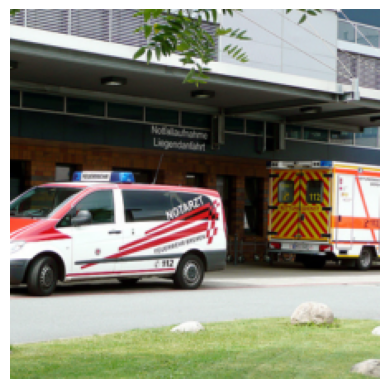

The prediction set is: [[' ambulance', 0.3864], [' moving van', 0.1212], [' tow truck', 0.0514], [' police van', 0.0491]]
The ground truth label is: ambulance


In [91]:
val_loader = load_imagenet(256,1234,False,norm=False)
i = 20390
img,label = val_loader.dataset[i]
prediction_set = sm_scores[i] > 1-qhat
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.show()
class_ids = [[val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[id]],round(torch.max(sm_scores[i][id]).item(),4)] for id in prediction_set.nonzero().view(-1)]
class_ids.sort(key = lambda x: -x[1])
print(f"The prediction set is: {class_ids}")
print(f"The ground truth label is:{val_loader.dataset.class_name_map[val_loader.dataset.class_id_list[label]]}")

# **Conformal Prediction Student Teacher**

We have the option of selecting the student or the teacher for prediction. We want to design a policy that determines when to select each. However, we want to gaurantee that our policy achieves a minimum level of performance. Specifically, we say that our policy must output predictions that match the teacher at least ($1-\alpha$) percent of the time. A trivial way to do this would be to just choose the teacher every time but this is not useful since it is too expensive. Formally we can say we want
$$\mathbb{P}(\mathcal{P}(x) \neq \mathcal{P}_t(x)) \leq \alpha$$

Let's say that the model chooses the student if confidence is above a threshold $\lambda$. Formally,
$$\mathcal{C}_\lambda(x) = \mathcal{P}_\lambda(x) = \begin{cases}\underset{k}{\text{argmax}}\,\,\hat{f}_s(x),& \text{max}\,\,\hat{f}_s(x) \geq \lambda\\
                         \underset{k}{\text{argmax}}\,\,\hat{f}_t(x),& \text{max}\,\,\hat{f}_s(x) < \lambda\end{cases}$$
Then, as $\lambda$ grows, the model picks the teacher more and becomes more conservative. We use conformal risk control to find the value $\hat{\lambda}$ such that we control for the fraction of time our policy will match the teacher model. Formally,
$$\mathbb{E}[\mathbf{1}_{\mathcal{P}_{\hat{\lambda}}(x_{test})\neq\mathcal{P}_t(x_{test})}] \leq \alpha$$

We can define the empirical risk as $\hat{R}(\lambda) = \frac{1}{n}\sum_{i=1}^n\mathbf{1}_{\mathcal{P}_{\lambda}(x_{test})\neq\mathcal{P}_t(x_{test})}$. Then we select $\hat{\lambda}$ as 
$$\hat{\lambda} = \text{inf }\Big\{\lambda : \frac{1}{n+1}(n\hat{R}(\lambda)+B) \leq \alpha\Big\}$$

In words, we select the threshold such that the policy matches at least $(1-\alpha)$ of the teacher's performance

Another idea, if we get a distribution shift then what can happen is that our policy may select the teacher too often or not too often because we become miscalibrated again. We can empirically calculate the value of alpha to during inference to see if it is being satisfied. If it is not then we can claim a distribution shift happen and redo the conformal process to derive a new value for lambda hat.

In [1]:
import torch
from scipy.optimize import brentq,root_scalar

In [2]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
# load the confidence scores
clean_embds,clean_labels,clean_preds = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)

In [3]:
# this is just for the first corruption
student_confs,student_decs = torch.max(clean_preds128,dim=1)
teacher_confs,teacher_decs = torch.max(clean_preds,dim=1)

student_confs_,student_decs_ = torch.max(corr_preds128[7],dim=1)
teacher_confs_,teacher_decs_ = torch.max(corr_preds[7],dim=1)

In [6]:
# generate the split, calibration on 1000 and validation on 49000
n = 1000
alpha = 0.1
rand_idxs = torch.randperm(50000)
rand_corr_order = torch.randperm(15)
cal_idxs = rand_idxs[:n]
val_idxs = rand_idxs[n:]

student_cal_scores = student_confs[cal_idxs]
student_cal_preds = student_decs[cal_idxs]
teacher_cal_preds = teacher_decs[cal_idxs]

student_val_scores = student_confs[val_idxs]
student_val_preds = student_decs[val_idxs]
teacher_val_preds = teacher_decs[val_idxs]

student_cal_scores_ = student_confs_[cal_idxs]
student_cal_preds_ = student_decs_[cal_idxs]
teacher_cal_preds_ = teacher_decs_[cal_idxs]

student_val_scores_ = student_confs_[val_idxs]
student_val_preds_ = student_decs_[val_idxs]
teacher_val_preds_ = teacher_decs_[val_idxs]

gt_vals = corr_labels[5][val_idxs]

In [58]:
v,i=torch.max(clean_preds128,dim=1)
v2,i2=torch.max(clean_preds128+noise,dim=1)

In [61]:
(i==i2).float().sum()

tensor(40300.)

In [79]:
lam_hats

[0.5518132746225918,
 0.5763290226462576,
 0.6070163548002904,
 0.6639468967922271,
 0.6872375309477816]

Text(0, 0.5, '$\\hat{R}(\\lambda)$')

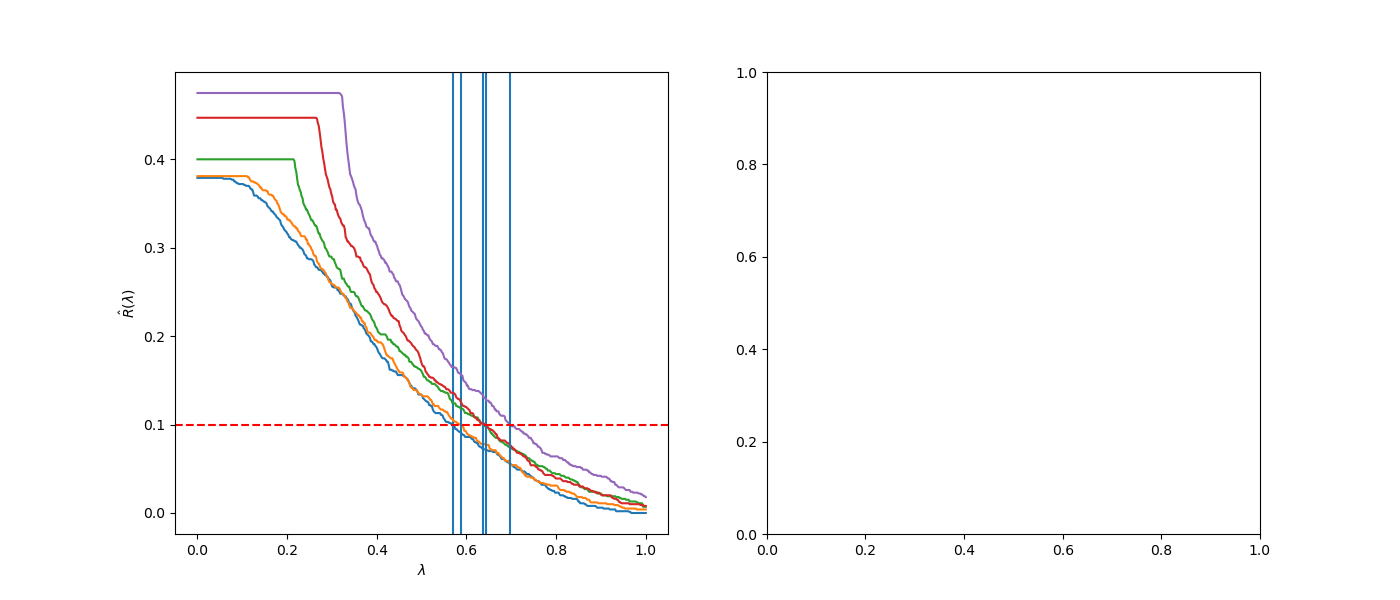

In [7]:
%matplotlib widget
# plot risk for different lambdas
import matplotlib.pyplot as plt
import numpy as np


y_ = []
alpha= 0.1
lams = np.linspace(0,1,500)

deltas = [0,2,4,5,6]
y = [[] for i in range(len(deltas))]
lam_threshs = [[] for i in range(len(deltas))]
lam_hats = []

for i,delta in enumerate(deltas):
    if delta > 0:
        noise = torch.rand(clean_preds.shape)-0.5
        noise128 = torch.rand(clean_preds128.shape)-0.5
        norms = torch.norm(noise,dim=1)*(1/delta)
        norms128 = torch.norm(noise128,dim=1)*(1/delta)
        noise /= norms[:,None]
        noise128 /= norms128[:,None]
        student_confs,student_decs = torch.max(clean_preds128+noise128,dim=1)
        teacher_confs,teacher_decs = torch.max(clean_preds+noise,dim=1)
    else:
        student_confs,student_decs = torch.max(clean_preds128,dim=1)
        teacher_confs,teacher_decs = torch.max(clean_preds,dim=1)


    student_cal_scores = student_confs[cal_idxs]
    student_cal_preds = student_decs[cal_idxs]
    teacher_cal_preds = teacher_decs[cal_idxs]

    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()
    def lamhat_threshold(lam): 
        p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
        return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1)) # why is this over n+1???

    
    for lam in lams:
        p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
        p_set_ = (student_cal_scores_ >= lam)*student_cal_preds_ + (student_cal_scores_ < lam)*teacher_cal_preds_
        y[i].append((p_set != teacher_cal_preds).float().mean())
        # y_.append((p_set_ != teacher_cal_preds_).float().mean())
        # lam_threshs[i].append(lamhat_threshold(lam))
    lam_hats.append(brentq(lamhat_threshold, 0, 1))

fig,ax = plt.subplots(1,2,figsize=(14,6))
for i in range(len(deltas)):
    ax[0].plot(lams,y[i],label=r"$\delta=$"+str(deltas[i]))
    ax[0].axvline(lam_hats[i])
    # ax[0].plot(lams,y_,label="corrupted data")
ax[0].axhline(alpha,c="r",linestyle="--")
# ax[0].axhline(0.2,c="r",linestyle="--")
# ax[0].axhline(0.3,c="r",linestyle="--")
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel("$\hat{R}(\lambda)$")

# ax[1].plot(lams,lam_threshs)


# if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
#     lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
# elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
#     lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
# else:
# for lth in lam_threshs:
#     # lamhat = brentq(lth, 0, 1)
#     ax[0].axvline(lam_hats[i],c='k',linestyle="--",label=r"$\alpha$ = 0.1")
# alpha = 0.2
# def lamhat_threshold(lam): 
#     p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
#     return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1)) # why is this over n+1???
# lamhat = brentq(lamhat_threshold, 0, 1)
# # ax[0].axvline(lamhat,c='k',linestyle="--",label=r"$\alpha$ = 0.2",alpha=0.5)
# alpha = 0.3
# def lamhat_threshold(lam): 
#     p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
#     return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1)) # why is this over n+1???
# lamhat = brentq(lamhat_threshold, 0, 1)
# ax[0].axvline(lamhat,c='k',linestyle="--",label=r"$\alpha$ = 0.3",alpha=0.25)
# ax[0].legend()

In [39]:
alphas = np.linspace(0,1,20)
lambdas = np.zeros(len(alphas))
lambdas_ = np.zeros(len(alphas))
st_match = np.zeros(len(alphas))
p_acc = np.zeros(len(alphas))
t_acc = np.zeros(len(alphas))

st_match_ = np.zeros(len(alphas))
p_acc_ = np.zeros(len(alphas))
t_acc_ = np.zeros(len(alphas))

st_match__ = np.zeros(len(alphas))
p_acc__ = np.zeros(len(alphas))
t_acc__ = np.zeros(len(alphas))
for i,alpha in enumerate(alphas):
    # zero-one loss
    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()

    # the lambda hat threshold, we want the largest lambda hat that we satisfy the condition
    def lamhat_threshold(lam): 
        p_set = (student_cal_scores >= lam)*student_cal_preds + (student_cal_scores < lam)*teacher_cal_preds
        return zo_loss(p_set, teacher_cal_preds) - ((n+1)/n*alpha - 1/(n+1))
    
    def lamhat_threshold_(lam): 
        p_set = (student_cal_scores_ >= lam)*student_cal_preds_ + (student_cal_scores_ < lam)*teacher_cal_preds_
        return zo_loss(p_set, teacher_cal_preds_) - ((n+1)/n*alpha - 1/(n+1))

    if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
    elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
    else:
        lamhat = brentq(lamhat_threshold, 0, 1)

    if lamhat_threshold_(0) <= 0 and lamhat_threshold_(1) <= 0:
        lamhat_ = max(lamhat_threshold(0),lamhat_threshold(1),0)
    elif lamhat_threshold_(0) >= 0 and lamhat_threshold_(1) >= 0:
        lamhat_ = max(lamhat_threshold_(0),lamhat_threshold_(1),1)
    else:
        lamhat_ = brentq(lamhat_threshold_, 0, 1)

    p_set = (student_val_scores >= lamhat)*student_val_preds + (student_val_scores < lamhat)*teacher_val_preds
    p_set_ = (student_val_scores_ >= lamhat)*student_val_preds_ + (student_val_scores_ < lamhat)*teacher_val_preds_
    p_set__ = (student_val_scores_ >= lamhat_)*student_val_preds_ + (student_val_scores_ < lamhat_)*teacher_val_preds_
    lambdas[i] = lamhat
    lambdas_[i] = lamhat_

    st_match[i] = (p_set == teacher_val_preds).float().mean()
    p_acc[i] = (p_set == gt_vals).float().mean()
    t_acc[i] = (teacher_val_preds == gt_vals).float().mean()

    st_match_[i] = (p_set_ == teacher_val_preds_).float().mean()
    p_acc_[i] = (p_set_ == gt_vals).float().mean()
    t_acc_[i] = (teacher_val_preds_ == gt_vals).float().mean()

    st_match__[i] = (p_set__ == teacher_val_preds_).float().mean()
    p_acc__[i] = (p_set__ == gt_vals).float().mean()
    t_acc__[i] = (teacher_val_preds_ == gt_vals).float().mean()
    # print(f"The empirical ZOL is: {zo_loss(p_set, teacher_val_preds)} and the threshold value is: {lamhat}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'accuracy')

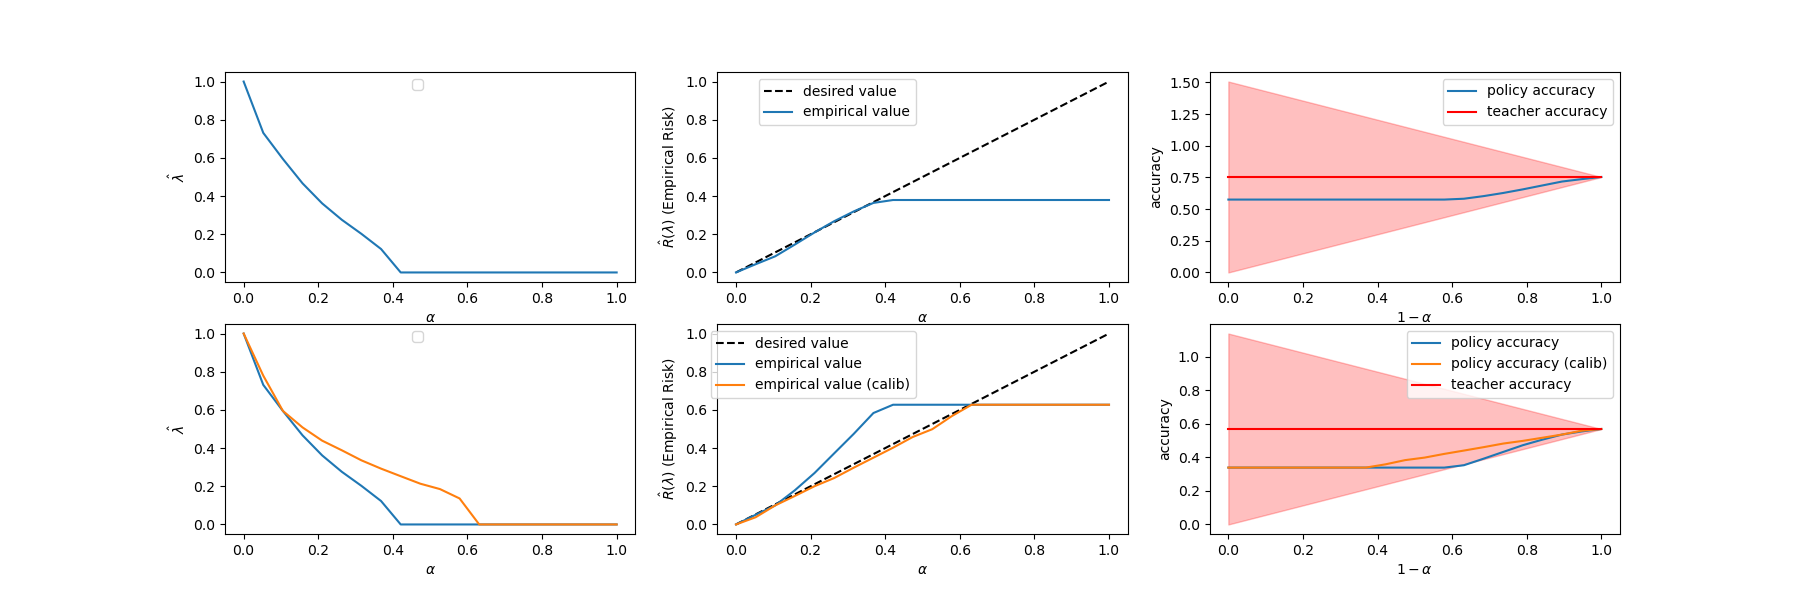

In [40]:
fig,ax = plt.subplots(2,3,figsize=(18,6))

ax[0,0].plot(alphas,lambdas)
ax[0,0].legend(bbox_to_anchor=(0.5,1))
ax[0,0].set_xlabel(r'$\alpha$')
ax[0,0].set_ylabel(r'$\hat{\lambda}$')

ax[1,0].plot(alphas,lambdas)
ax[1,0].plot(alphas,lambdas_)
ax[1,0].legend(bbox_to_anchor=(0.5,1))
ax[1,0].set_xlabel(r'$\alpha$')
ax[1,0].set_ylabel(r'$\hat{\lambda}$')

ax[0,1].plot(alphas,alphas,linestyle="--",c='k',label="desired value")
ax[0,1].plot(alphas,1-st_match,label="empirical value")
ax[0,1].legend(bbox_to_anchor=(0.5,1))
ax[0,1].set_xlabel(r'$\alpha$')
ax[0,1].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')

y_err_m = t_acc - (alphas)*t_acc
y_err_p = t_acc + (alphas)*t_acc
ax[0,2].plot(1-alphas,p_acc,label="policy accuracy")
ax[0,2].plot(1-alphas,t_acc,label="teacher accuracy",c='r')
ax[0,2].fill_between(1-alphas,y_err_m,y_err_p,color='r',alpha=0.25)
ax[0,2].legend(bbox_to_anchor=(1,1))
ax[0,2].set_xlabel(r'$1-\alpha$')
ax[0,2].set_ylabel("accuracy")

ax[1,1].plot(alphas,alphas,linestyle="--",c='k',label="desired value")
ax[1,1].plot(alphas,1-st_match_,label="empirical value")
ax[1,1].plot(alphas,1-st_match__,label="empirical value (calib)")
ax[1,1].legend(bbox_to_anchor=(0.5,1))
ax[1,1].set_xlabel(r'$\alpha$')
ax[1,1].set_ylabel(r'$\hat{R}(\lambda)$ (Empirical Risk)')

y_err_m = t_acc_ - (alphas)*t_acc_
y_err_p = t_acc_ + (alphas)*t_acc_
ax[1,2].plot(1-alphas,p_acc_,label="policy accuracy")
ax[1,2].plot(1-alphas,p_acc__,label="policy accuracy (calib)")
ax[1,2].plot(1-alphas,t_acc_,label="teacher accuracy",c='r')
ax[1,2].fill_between(1-alphas,y_err_m,y_err_p,color='r',alpha=0.25)
ax[1,2].legend(bbox_to_anchor=(1,1))
ax[1,2].set_xlabel(r'$1-\alpha$')
ax[1,2].set_ylabel("accuracy")

the reason the policy is able to stay within the red region while we cross over the risk boundary is that the risk is in terms of how the policies match which is not exactly the accuracy value. For example, there is a non-trivial amount of times where the student is actually right when it disagrees with the teacher so in reality the worst case scenario is that the student is wrong every time it disagrees with the teacher but in reality there are a non negligible amount of times it is correct. For example, at alpha = 0.4, our empirical risk is around 0.625, meaning that we wanted to agree with the teacher at least 60% of the time but we only agree 37.75% of the time. In the snippet below we see that the student is actually correct 6.7% of the time when it disagrees. We 

In [284]:
disag_idxs = (student_val_preds_ != teacher_val_preds_).nonzero().view(-1)
ag_idxs = (student_val_preds_ == teacher_val_preds_).nonzero().view(-1)
print((student_val_preds_[disag_idxs] == gt_vals[disag_idxs]).float().sum())
print((student_val_preds_[ag_idxs] == gt_vals[ag_idxs]).float().sum())
print((teacher_val_preds_[disag_idxs] == gt_vals[disag_idxs]).float().sum())

tensor(2051.)
tensor(14537.)
tensor(13325.)


In [281]:
16/50

0.32

In [247]:
print(lambdas)

[1.         0.74353877 0.59248778 0.48214315 0.39205508 0.32006617
 0.25055896 0.16271187 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


plot interpertation: alpha is a user determined value, it is the desired probability that our policy does not match the teacher. In other words, we want our policy to do at least as well as (1-alpha) the teachers performance, or we want our model to do no worse than alpha percent of the teachers performance. For example, if alpha is 0.1, we want our model to do no worse than 0.1*t_acc.

In [1]:
import numpy as np
import cvxpy as cp

In [5]:
confs-lam_hat

Expression(AFFINE, UNKNOWN, (4,))

In [2]:
confs = np.array([0.1,0.5,0.9,0.2])
avg = np.ones(len(confs))/len(confs)
ones = np.ones(len(confs))

lam_hat = cp.Variable(1)
y_pos = cp.Variable(4,boolean=True)
constraints = [((confs-lam_hat*ones)*y_pos)@avg <= 0.1, -y_pos <= (confs-lam_hat*ones), (confs-lam_hat*ones) <= (1-y_pos)]

problem = cp.Problem(cp.Minimize(lam_hat), constraints)

problem.solve(verbose=True)
print("status:", problem.status)

/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


ValueError: Scalar operands are not allowed, use '*' instead